In [47]:
library(ggplot2)
library(dplyr)
library(ggdist)
library(lme4)
library(ggeffects)
library(patchwork)
library(lmerTest)
library(brms)
library(blme)
library(rlang)
library(glmmTMB)

library(broom.mixed)


In [3]:
# Load data
data <- read.csv("data/studyResultsPilot.csv", header=T)

data <- data %>%
  mutate(anchor = ifelse(anchorCategory == "anchor", "anchor", "non-anchor"))

data <- data %>%
  mutate(alignment = ifelse(alignmentCategory == "aligned", "aligned", "unaligned"))

data <- data %>%
  mutate(anchorType = case_when(
    selectedPart == 25 ~ "25",
    selectedPart == 50 ~ "50",
    TRUE ~ "non-anchor"
))

data$alignmentCategory <- factor(data$alignmentCategory, levels = c("aligned", "near-aligned", "far-from-aligned"))
data$anchorCategory <- factor(data$anchorCategory, levels = c("anchor", "near-anchor", "far-anchor"))

data$distToNearest5 <- abs(data$selectedPart - round(data$selectedPart / 5) * 5)
data$distToNearest10 <- abs(data$selectedPart - round(data$selectedPart / 10) * 10)

head(data)

,responseTime,prolificID,userID,questionNum,response,loadTime,questionID,selectedPart,alignmentCategory,anchorCategory,⋯,F_ind,G_ind,error,absError,correct,anchor,alignment,anchorType,distToNearest5,distToNearest10
,<dbl>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<fct>,<fct>,⋯,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,11.048,67bdb56696615a171c91c62c,1,1,55,2025-04-21 19:28:36.484,1,40,aligned,far-anchor,⋯,3,0,15,15,False,non-anchor,aligned,non-anchor,0,0
2,7.346,67bdb56696615a171c91c62c,1,2,15,2025-04-21 19:28:47.809,2,46,far-from-aligned,near-anchor,⋯,1,3,-31,31,False,non-anchor,unaligned,non-anchor,1,4
3,6.502,67bdb56696615a171c91c62c,1,3,80,2025-04-21 19:28:55.420,3,21,near-aligned,near-anchor,⋯,0,2,59,59,False,non-anchor,unaligned,non-anchor,1,1
4,5.066,67bdb56696615a171c91c62c,1,4,22,2025-04-21 19:29:02.263,4,19,near-aligned,far-anchor,⋯,4,6,3,3,False,non-anchor,unaligned,non-anchor,1,1
5,4.608,67bdb56696615a171c91c62c,1,5,18,2025-04-21 19:29:07.603,5,35,far-from-aligned,far-anchor,⋯,1,6,-17,17,False,non-anchor,unaligned,non-anchor,0,5
6,11.841,67bdb56696615a171c91c62c,1,6,22,2025-04-21 19:29:12.481,6,18,far-from-aligned,far-anchor,⋯,4,5,4,4,False,non-anchor,unaligned,non-anchor,2,2


In [61]:
model <- glmmTMB(
  absError ~ (chartType * anchor * alignment) + distToNearest5 + (1 + anchor + alignment + chartType + distToNearest5 || userID),
  data = data,
  family = tweedie(link = "log")
)

summary(model)

 Family: tweedie  ( log )
Formula:          
absError ~ (chartType * anchor * alignment) + distToNearest5 +  
    (1 + anchor + alignment + chartType + distToNearest5 || userID)
Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
   5383.7    5461.6   -2675.8    5351.7       946 

Random effects:

Conditional model:
 Groups Name               Variance  Std.Dev.  Corr                
 userID (Intercept)        1.876e+00 1.370e+00                     
        anchornon-anchor   4.837e-01 6.955e-01 0.00                
        alignmentunaligned 2.763e-02 1.662e-01 0.00 0.00           
        chartTypepie       3.425e-02 1.851e-01 0.00 0.00 0.00      
        distToNearest5     1.259e-09 3.549e-05 0.00 0.00 0.00 0.00 
Number of obs: 962, groups:  userID, 10

Dispersion parameter for tweedie family (): 2.14 

Conditional model:
                                                 Estimate Std. Error z value
(Intercept)                                       1.38944    0.48655   2.85

In [40]:
# Get unique user IDs
users <- unique(data$userID)

# Sample 60 user IDs with replacement
set.seed(123)
new_user_ids <- sample(users, size = 60, replace = TRUE)

# Bootstrap participants and assign new IDs
boot_data <- do.call(rbind, lapply(seq_along(new_user_ids), function(i) {
  user_data <- data %>% filter(userID == new_user_ids[i])
  user_data$userID <- paste0("boot_", i)
  user_data
}))

boot_model <- glmmTMB(
  absError ~ chartType * (anchor + alignment) + distToNearest5 + (1 + anchor + alignment + distToNearest5 || userID),
  data = boot_data,
  family = tweedie(link = "log")
)

summary(boot_model)

 Family: tweedie  ( log )
Formula:          
absError ~ chartType * (anchor + alignment) + distToNearest5 +  
    (1 + anchor + alignment + distToNearest5 || userID)
Data: boot_data

      AIC       BIC    logLik -2*log(L)  df.resid 
  32159.0   32245.6  -16066.5   32133.0      5769 

Random effects:

Conditional model:
 Groups Name               Variance  Std.Dev.  Corr           
 userID (Intercept)        1.660e+00 1.288e+00                
        anchornon-anchor   4.224e-01 6.499e-01 0.00           
        alignmentunaligned 1.249e-02 1.117e-01 0.00 0.00      
        distToNearest5     1.559e-09 3.948e-05 0.00 0.00 0.00 
Number of obs: 5782, groups:  userID, 60

Dispersion parameter for tweedie family (): 2.25 

Conditional model:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      1.017147   0.180949   5.621 1.90e-08 ***
chartTypepie                    -0.278167   0.084267  -3.301 0.000963 ***
anchornon-anchor             

In [53]:
simulate <- function(data, n_participants) {
  users <- unique(data$userID)
  sampled_users <- sample(users, size = n_participants, replace = TRUE)

  boot_data <- do.call(rbind, lapply(seq_along(sampled_users), function(i) {
    d <- data %>% filter(userID == sampled_users[i])
    d$userID <- paste0("boot_", i)
    return(d)
  }))

  # Fit Tweedie model
  model <- tryCatch({
    glmmTMB(
      absError ~ chartType * (anchor + alignment) + distToNearest5 +
        (1 + anchor + alignment + distToNearest5 || userID),
      data = boot_data,
      family = tweedie(link = "log")
    )
  }, error = function(e) return(NULL))

  if (is.null(model)) return(rep(NA, 5))

  # Extract p-values from fixed effects
  tidy_mod <- broom.mixed::tidy(model)
  pvals <- tidy_mod$p.value
  names(pvals) <- tidy_mod$term

  return(c(
    chartType = as.numeric(pvals["chartTypepie"] < 0.05),
    anchor = as.numeric(pvals["anchornon-anchor"] < 0.05),
    alignment = as.numeric(pvals["alignmentunaligned"] < 0.05),
    chartType_anchor = as.numeric(pvals["chartTypepie:anchornon-anchor"] < 0.05),
    chartType_alignment = as.numeric(pvals["chartTypepie:alignmentunaligned"] < 0.05)
  ))
}

In [ ]:
participants <- c(10, 20, 40, 50, 60, 70, 80)
simulationCount <- 60

set.seed(123)
results <- lapply(participants, function(n) {
  simMatrix <- replicate(simulationCount, simulate(data, n))
  propSig <- rowMeans(simMatrix, na.rm = TRUE)
  data.frame(N = n, t(propSig))
})

power_df <- bind_rows(results)
power_long <- tidyr::pivot_longer(power_df, -N, names_to = "Effect", values_to = "Power")

Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')”
Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')”
Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')”
Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')”
Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')”
Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshoo

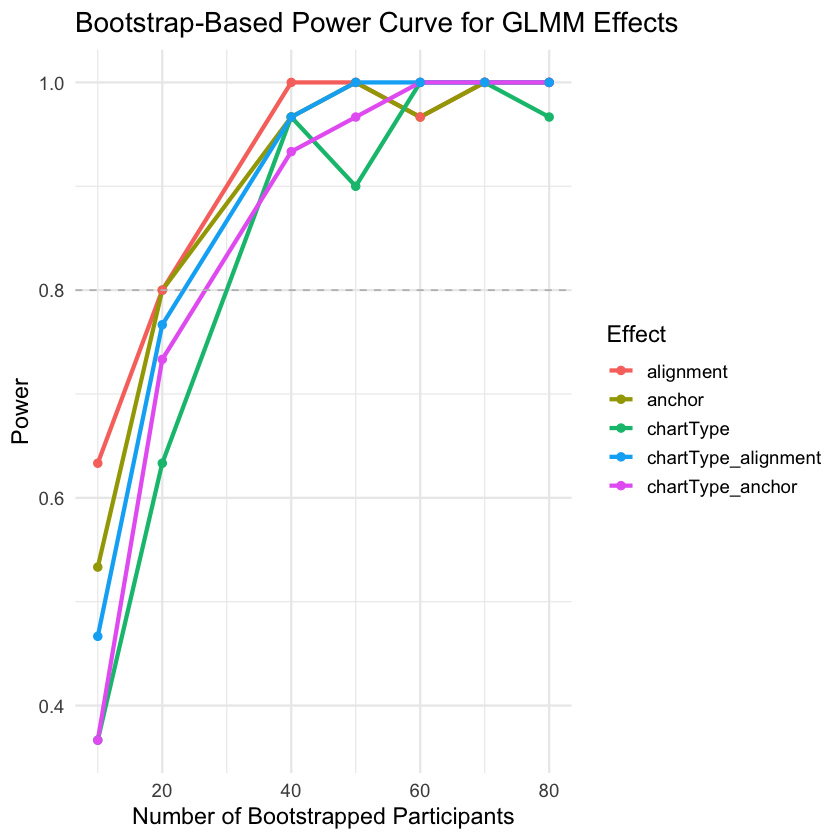

In [ ]:
# Plot power curve
ggplot(power_long, aes(x = N, y = Power, color = Effect)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  geom_hline(yintercept = 0.8, linetype = "dashed", color = "gray") +
  theme_minimal(base_size = 14) +
  labs(
    title = "Bootstrap-Based Power Curve for GLMM Effects",
    x = "Number of Bootstrapped Participants",
    y = "Power",
    color = "Effect"
  )

In [ ]:
# Create a range of sample sizes
models <- list()
powers <- numeric()

for (n in seq(20, 100, by=10)) {
  temp_model <- extend(model, along="userID", n=n)
  sim <- powerSim(temp_model, fixed("anchor", "lr"), nsim=5)
  powers <- c(powers, sim$power)
  models[[as.character(n)]] <- sim
}

# Plot the power curve
plot(seq(20, 100, by=10), powers, type="b", xlab="Sample Size (Participants)", ylab="Power", main="Power Curve")
abline(h=0.8, col="red", lty=2)  # 80% power threshold


In [23]:
# Get unique user IDs
users <- unique(data$userID)

# Sample 60 user IDs with replacement
set.seed(123)
new_user_ids <- sample(users, size = 60, replace = TRUE)

# Bootstrap participants and assign new IDs
boot_data <- do.call(rbind, lapply(seq_along(new_user_ids), function(i) {
  user_data <- data %>% filter(userID == new_user_ids[i])
  user_data$userID <- paste0("boot_", i)
  user_data
}))

In [26]:
boot_model <- lmer(
  absError ~ chartType * (anchor + alignment) + (1 | userID),
  data = boot_data
)
summary(boot_model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: absError ~ chartType * (anchor + alignment) + (1 | userID)
   Data: boot_data

REML criterion at convergence: 39797.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3767 -0.4084 -0.1494  0.2154  6.4258 

Random effects:
 Groups   Name        Variance Std.Dev.
 userID   (Intercept) 28.34    5.323   
 Residual             54.89    7.408   
Number of obs: 5782, groups:  userID, 60

Fixed effects:
                                 Estimate Std. Error        df t value Pr(>|t|)
(Intercept)                        5.9665     0.8169  112.9874   7.304 4.21e-11
chartTypepie                      -1.0285     0.6248 5716.9944  -1.646   0.0998
anchornon-anchor                   0.4440     0.4177 5716.9981   1.063   0.2879
alignmentunaligned                 1.2878     0.3093 5717.0015   4.164 3.17e-05
chartTypepie:anchornon-anchor      1.4142     0.5910 5716.9958   2.393   0.0167
chartTypepi

In [28]:
power_result <- powerSim(boot_model, fixed("anchor", "lr"), nsim=50)
print(power_result)

Simulating: |                                                                  |

Simulating: |=                                                                Simulating: |==                                                               Simulating: |===                                                              Simulating: |=====                                                            Simulating: |======                                                           Simulating: |=======                                                          Simulating: |=========                                                        Simulating: |==========                                                       Simulating: |===========                                                      Simulating: |=============                                                    Simulating: |==============                                                   Simulating: |===============                                                  Simulating: |=================                                  

Warning message in observedPowerWarning(sim):
“This appears to be an "observed power" calculation”


Power for predictor 'anchor', (95% confidence interval):
       0.00% ( 0.00,  7.11)

Test: Likelihood ratio

Based on 50 simulations, (50 warnings, 50 errors)
alpha = 0.05, nrow = 5782

Time elapsed: 0 h 2 m 25 s

nb: result might be an observed power calculation
